# Explore SGP's ARM data, detrend and apply bias correction
- In this notebook, we process Southern Great Plain's (SGP) Atmospheric Radiation Measurement (ARM) data.
- There is one file per day with each file containing one data for every minute .
- So, we compute daily max for the variable temperature and store it in a zarr store.
- We fill missing data with NaNs.
- Before doing analysis on days of the year with one or more NaNs for the period 1994-2024, please resample and fill the NaNs
- In this notebook, we use data for the day Jul 30 which doesn't have missing data

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
sgp_lat   = 36.607
sgp_lon   = (360-97.487)%360
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
sgp_rawdpath = rda_data + 'sgp_data/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
#
print(sgp_lat,sgp_lon)

36.607 262.51300000000003


In [4]:
def to_daily(ds):
    year = ds.time.dt.year
    day  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time") 

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [5]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')

In [6]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = obs_mean + (final_mean - init_mean) + ds_obs - obs_mean        
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

def min_sorting(arr):
    # Convert to a NumPy array if not already
    arr = np.array(arr)

    # Find indices where the array is not sorted
    unsorted_indices = np.where(arr[:-1] > arr[1:])[0]

    # Iterate through unsorted indices and min with minimum of subsequent values
    for i in unsorted_indices:
        arr[i] = np.min(arr[i:])
    
    # Adjust for duplicates
    unique_elements, counts = np.unique(arr, return_counts=True)
    duplicates              = unique_elements[counts > 1]

    for d in duplicates:
        indices = np.where(arr == d)[0]
        for i, idx in enumerate(indices):
            arr[idx] += i * 1e-4

    return arr

In [7]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

In [8]:
# Create the client to load the Dashboard
client = Client(cluster)

In [9]:
n_workers = 5 
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(62b0778e, 'tcp://128.117.208.98:35521', workers=5, threads=5, memory=80.00 GiB)

In [10]:
pi_year0  = '1850'
pi_year1  = '1879'
#
ic_year0  = '2071'
ic_year1  = '2100'
#
sgp_year0 = '1994'
sgp_year1 = '2023'
#
pi_year   = 1865
eoc_year  = 2085
cur_year  = 2009
doy       = 211 # day_of_year
date = no_leap_date(doy)
date

'July 30'

## Section 2: Load SGP raw data 

### Test file paths by reading one year's worth of data

In [11]:
# Define the start and end dates
start_date = datetime(2013, 1, 1)
end_date   = datetime(2013, 12, 31)

# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'

# Generate the dates and create file paths
file_paths = []
current_date = start_date
#
while current_date <= end_date:
    date_str = current_date.strftime('%Y%m%d')
    file_path = string1 + date_str + string2
    file_paths.append(file_path)
    current_date += timedelta(days=1)

# File_paths now contains all the generated file paths
# print(file_paths)

In [12]:
%%time
sgp = xr.open_mfdataset(file_paths,combine='nested',concat_dim='time')
sgp

CPU times: user 13.5 s, sys: 640 ms, total: 14.1 s
Wall time: 25.1 s


<xarray.Dataset> Size: 123MB
Dimensions:                       (time: 522241)
Coordinates:
  * time                          (time) datetime64[ns] 4MB 2013-01-01 ... 20...
Data variables: (12/49)
    base_time                     (time) datetime64[ns] 4MB 2012-12-31T23:07:...
    time_offset                   (time) datetime64[ns] 4MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_time                       (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    atmos_pressure                (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure             (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean                     (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    logger_temp                   (time) float32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_logger_temp                (time) int32 2MB dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                           (time) float32 2MB 36.6 36.6 ... 36.6 36.6
    lon                           (time) float32 2MB -97.49 -97.49 ... -97.49
    alt                           (time) float32 2MB 318.0 318.0 ... 318.0 318.0
Attributes: (12/29)
    command_line:                met_ingest -s sgp -f E13
    process_version:             ingest-met-4.10-0.el5
    dod_version:                 met-b1-2.2
    site_id:                     sgp
    facility_id:                 E13: Lamont, Oklahoma
    data_level:                  b1
    ...                          ...
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    zeb_platform:                sgpmetE13.b1
    history:                     created by user dsmgr on machine iron at 1-J...

In [13]:
# %%time
# test = xr.open_dataset('/global/scratch/users/harsha/SGP/raw_data/sgpmetE13.b1.20131230.000000.cdf')
# test

### Process observations (ARM) data, compute daily max and write files to daily file

In [14]:
# Define string1 and string2
string1 = sgp_rawdpath +'sgpmetE13.b1.'
string2 = '.000000.cdf'
variable_name = 'temp_mean'  # The variable you want to extract
#
year_0      = 1993
year_1      = 2023

In [15]:
# %%time
# tmax_arrays = []
# tmin_arrays = []
# tmean_arrays = []

# for year in range(year_0, year_1 + 1):
#     daily_max_values  = []
#     daily_min_values  = []
#     daily_mean_values = []

#     # Iterate over each day of the year
#     for day in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31'):
#         date_str = day.strftime('%Y%m%d')
#         file_path = string1 + date_str + string2

#         try:
#             with xr.open_dataset(file_path) as ds:
#                 daily_max  = ds[variable_name].max(dim='time')
#                 daily_min  = ds[variable_name].min(dim='time')
#                 daily_mean = ds[variable_name].mean(dim='time')
#                 #
#                 daily_max_values.append(daily_max.values)
#                 daily_min_values.append(daily_min.values)
#                 daily_mean_values.append(daily_mean.values)
#                 #
#         except (FileNotFoundError):
#             # print(f"File not found: {file_path}")
#             daily_max_values.append(np.nan)  # Append NaN for missing data
#             daily_min_values.append(np.nan)
#             daily_mean_values.append(np.nan)

#     # Combine daily maximum values into a DataArray for the year
#     yearly_data_max = xr.DataArray(daily_max_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year}) 
#     ###
#     yearly_data_min = xr.DataArray(daily_min_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year})
#     #####
#     yearly_data_mean = xr.DataArray(daily_mean_values, dims=["dayofyear"], coords={"dayofyear": pd.date_range(start=f'{year}-01-01',\
#                                                                             end=f'{year}-12-31').dayofyear, "year": year})
    
    
#     tmax_arrays.append(yearly_data_max)
#     tmin_arrays.append(yearly_data_min)
#     tmean_arrays.append(yearly_data_mean)

# # Concatenate all yearly data arrays along the new 'year' coordinate
# tmax_data  = xr.concat(tmax_arrays, dim='year')
# tmin_data  = xr.concat(tmin_arrays, dim='year')
# tmean_data = xr.concat(tmean_arrays, dim='year')

# # Save the concatenated data to a single file
# tmax_data.rename('tmax').to_dataset().to_zarr(tmax_path + 'tmax_sgp_obs.zarr',mode='w')
# tmin_data.rename('tmin').to_dataset().to_zarr(tmin_path + 'tmin_sgp_obs.zarr',mode='w')
# tmean_data.rename('tmean').to_dataset().to_zarr(tmean_path +'tmean_sgp_obs.zarr',mode='w')

In [16]:
sgp_tmax = xr.open_zarr(tmax_path + 'tmax_sgp_obs.zarr')
sgp_tmin = xr.open_zarr(tmin_path + 'tmin_sgp_obs.zarr')
sgp_tmean = xr.open_zarr(tmean_path + 'tmean_sgp_obs.zarr')
#
sgp_tmax  =  sgp_tmax['tmax']
sgp_tmin  =  sgp_tmin['tmin']
sgp_tmean =  sgp_tmean['tmean']
sgp_tmax

<xarray.DataArray 'tmax' (year: 31, dayofyear: 366)> Size: 91kB
dask.array<open_dataset-tmax, shape=(31, 366), dtype=float64, chunksize=(31, 366), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int32 1kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * year       (year) int64 248B 1993 1994 1995 1996 ... 2020 2021 2022 2023

In [17]:
%%time
sgp_tmax.sel(dayofyear=doy).values

CPU times: user 117 ms, sys: 1.77 ms, total: 118 ms
Wall time: 2.04 s


array([        nan, 30.52000046, 32.65999985, 31.95999908, 29.54000092,
       35.84999847, 40.25      , 30.81999969, 38.52000046, 33.11000061,
       34.72000122, 21.62000084, 36.33000183, 38.16999817, 33.20999908,
       34.79000092, 27.48999977, 36.66999817, 38.70999908, 42.79000092,
       30.51000023, 28.29000092, 29.39999962, 28.30999947, 31.43000031,
       30.07999992, 36.18000031, 32.29000092, 37.91999817, 28.45000076,
       38.5       ])

### Drop data for 366th day, the year 1993 and convert to Kelvin

In [18]:
%%time
sgp_tmax = sgp_tmax.drop_isel(dayofyear = 365, year=0).rename({'dayofyear':'day'}) + 273.15
sgp_tmax.sel(day=doy).dropna(dim='year').values

CPU times: user 173 ms, sys: 1.17 ms, total: 174 ms
Wall time: 2.19 s


array([303.67000046, 305.80999985, 305.10999908, 302.69000092,
       308.99999847, 313.4       , 303.96999969, 311.67000046,
       306.26000061, 307.87000122, 294.77000084, 309.48000183,
       311.31999817, 306.35999908, 307.94000092, 300.63999977,
       309.81999817, 311.85999908, 315.94000092, 303.66000023,
       301.44000092, 302.54999962, 301.45999947, 304.58000031,
       303.22999992, 309.33000031, 305.44000092, 311.06999817,
       301.60000076, 311.65      ])

### Quantile function

#### Resample and fill-in missing values

In [19]:
# # Set the random seed for reproducibility
# random_state = 42
# np.random.seed(random_state)
# sgp_tmax_dobs = sgp_tmax_obs.sel(day=doy).values
# # Identify non-missing values
# non_missing = sgp_tmax_dobs[~np.isnan(sgp_tmax_dobs)]

# # Randomly sample from non-missing values
# # The size of the sample is equal to the number of missing values
# sampled_values = np.random.choice(non_missing, size=np.isnan(sgp_tmax_dobs).sum())

# # Fill in the missing values
# sgp_tmax_dobs[np.isnan(sgp_tmax_dobs)] = sampled_values
# sgp_tmax_dobs

### Now get model data 

In [27]:
%%time
cur_tmax  = xr.open_zarr(tmax_path +'cur_detrended_tmax.zarr')
eoc_tmax  = xr.open_zarr(tmax_path + 'eoc_detrended_tmax.zarr')
cur_tmax  = cur_tmax['detrended_tmax']
eoc_tmax  = eoc_tmax['detrended_tmax']
#
cur_tmean  = xr.open_zarr(tmean_path +'cur_detrended_tmean.zarr')
eoc_tmean  = xr.open_zarr(tmean_path + 'eoc_detrended_tmean.zarr')
cur_tmean  = cur_tmean['detrended_tmean']
eoc_tmean  = eoc_tmean['detrended_tmean']
#
cur_tmin  = xr.open_zarr(tmin_path +'cur_detrended_tmin.zarr')
eoc_tmin  = xr.open_zarr(tmin_path + 'eoc_detrended_tmin.zarr')
cur_tmin  = cur_tmin['detrended_tmin']
eoc_tmin  = eoc_tmin['detrended_tmin']

CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 36.6 ms


In [28]:
%%time
cur_sgp_tmax  = cur_tmax.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmax  = eoc_tmax.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)   
#
cur_sgp_tmin   = cur_tmin.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmin   = eoc_tmin.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy) 
#
cur_sgp_tmean  = cur_tmean.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp_tmean  = eoc_tmean.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy) 
eoc_sgp_tmean

CPU times: user 62.2 ms, sys: 12.7 ms, total: 74.8 ms
Wall time: 90 ms


<xarray.DataArray 'detrended_tmean' (member_id: 100, year: 30)> Size: 24kB
dask.array<getitem, shape=(100, 30), dtype=float64, chunksize=(1, 30), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 8B 211
    degree     int64 8B ...
    lat        float64 8B 36.28
    lon        float64 8B 262.5
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100

## Section 3: Data Analysis

### Apply Moment Delta Mapping and Quantile Delta Mapping for each member

In [29]:
####### Tmax ###############
eoc_sgp_mean_tmax = eoc_sgp_tmax.mean({'year'})
eoc_sgp_std_tmax  = eoc_sgp_tmax.std({'year'})
#
cur_sgp_mean_tmax = cur_sgp_tmax.mean({'year'})
cur_sgp_std_tmax = cur_sgp_tmax.std({'year'})

#### Tmean #########
eoc_sgp_mean_tmean = eoc_sgp_tmean.mean({'year'})
eoc_sgp_std_tmean  = eoc_sgp_tmean.std({'year'})
#
cur_sgp_mean_tmean = cur_sgp_tmean.mean({'year'})
cur_sgp_std_tmean  = cur_sgp_tmean.std({'year'})
##### Tmin #########
eoc_sgp_mean_tmean

<xarray.DataArray 'detrended_tmean' (member_id: 100)> Size: 800B
dask.array<mean_agg-aggregate, shape=(100,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 8B 211
    degree     int64 8B ...
    lat        float64 8B 36.28
    lon        float64 8B 262.5
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'

In [33]:
#### Temp #####
cur_sgp_mean_tmean.isel(member_id=10).values, cur_sgp_mean_tmean.isel(member_id=10).values

(array(307.75516438), array(307.75516438))

In [27]:
sgp_cur_std_mem.sel(day=doy,member=10).values, sgp_eoc_std_mem.sel(day=doy,member=10).values

(array(2.42764111), array(4.22046322))

In [28]:
sgp_mdm_mem   =   implement_mdm(sgp_obs,sgp_cur_mean_mem,sgp_eoc_mean_mem,sgp_cur_std_mem,sgp_eoc_std_mem)
#sgp_mdm.sel(day=doy).values
sgp_mdm_mem

<xarray.DataArray (day: 365, member: 100, year: 30)>
dask.array<add, shape=(365, 100, 30), dtype=float64, chunksize=(365, 100, 30), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    lat      float64 36.28
    lon      float64 262.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    degree   int64 1
  * year     (year) int64 1994 1995 1996 1997 1998 ... 2019 2020 2021 2022 2023

In [29]:
%%time
# Compute quantiles
qsgp_mdm_mem = compute_quantiles(sgp_mdm_mem)
qsgp_obs     = compute_quantiles(sgp_obs)
#
qsgp_cur_mem = sgp_model_cur.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
qsgp_eoc_mem = sgp_model_eoc.chunk(dict(year=-1)).quantile(quants, dim='year',skipna=False)
#
qdeltas_mem  = qsgp_eoc_mem - qsgp_cur_mem
qsgp_qdm_mem = implement_qdm(qsgp_obs,qsgp_cur_mem,qsgp_eoc_mem)
qsgp_qdm_mem

CPU times: user 277 ms, sys: 6.32 ms, total: 283 ms
Wall time: 285 ms


<xarray.DataArray (quantile: 30, day: 365, member: 100)>
dask.array<add, shape=(30, 365, 100), dtype=float64, chunksize=(30, 365, 100), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [30]:
# Now, calculate QDM + sort
qsgp_sqdm_mem  = xr.apply_ufunc(
    np.sort,
    qsgp_qdm_mem,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
qsgp_sqdm_mem

<xarray.DataArray (day: 365, member: 100, quantile: 30)>
dask.array<transpose, shape=(365, 100, 30), dtype=float64, chunksize=(365, 100, 30), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

CPU times: user 4.29 s, sys: 206 ms, total: 4.49 s
Wall time: 6.59 s


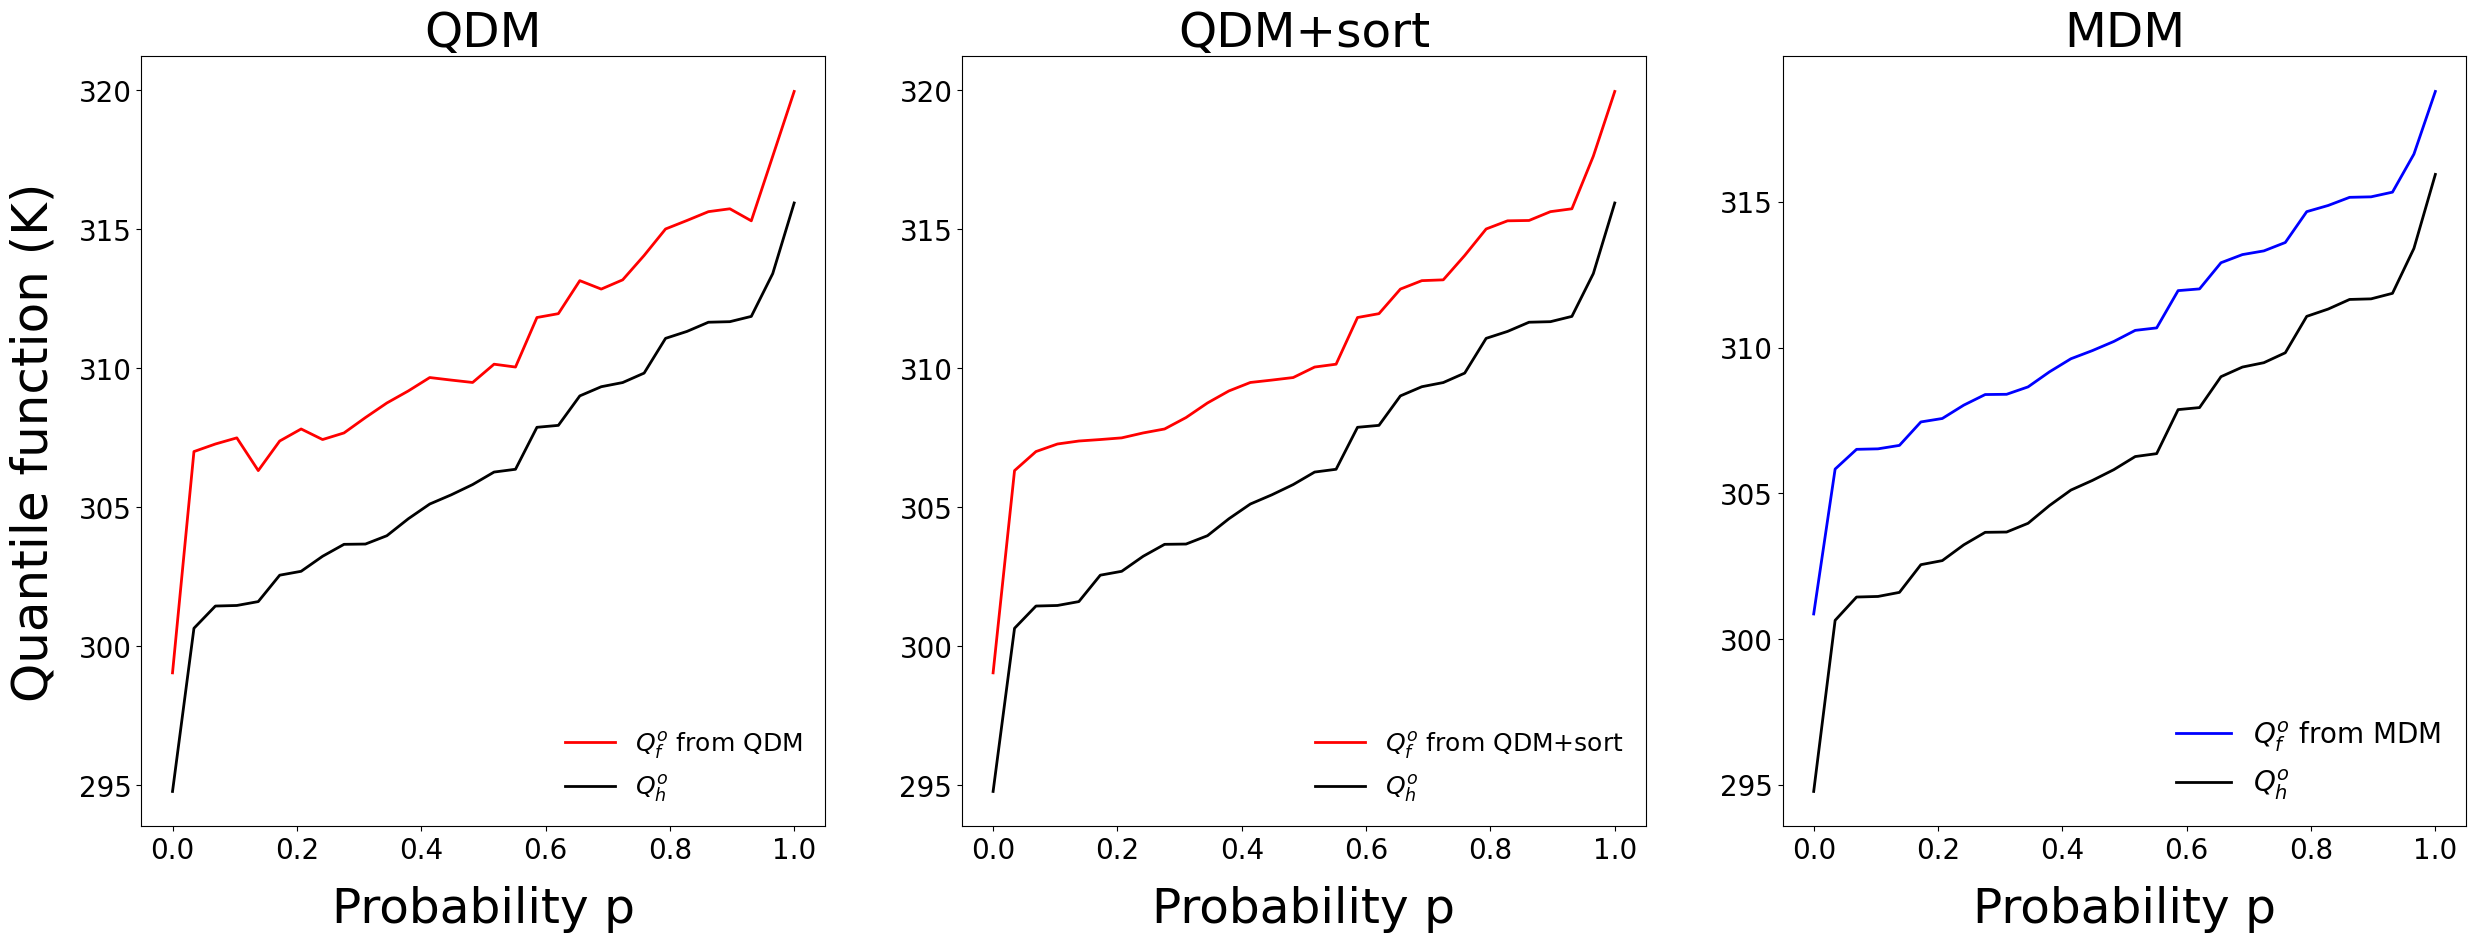

In [31]:
%%time
member = 0
# Plot the 3 figures as a 3-panel plot
# Setting up the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) # 3 plots - side by side

#Plot for QDM
# axs[0].plot(quants,qsgp_eoc.sel(day=doy,member=member),color= 'orange', label='EOC: model')
# axs[0].plot(quants,qsgp_cur.sel(day=doy,member=member), color='blue',label ='Current: model')
axs[0].plot(quants,qsgp_qdm_mem.sel(day=doy,member=member),'r',label=r'$Q_f^o$ from QDM',lw=2)
axs[0].plot(quants,qsgp_obs.sel(day=doy),'k', label =r'$Q_h^o$',lw=2)
axs[0].set_ylabel('Quantile function (K)',fontweight=500,fontsize=36,labelpad=15)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[0].set_title('QDM',fontweight=500,fontsize=35)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].legend(loc='lower right',prop={'size': 18},frameon=False)

#Plot for QDM + sort
# axs[1].plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
# axs[1].plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
axs[1].plot(quants,qsgp_sqdm_mem.sel(day=doy,member=member),'r',label=r'$Q_f^o$ from QDM+sort',lw=2)
axs[1].plot(quants,qsgp_obs.sel(day=doy),'k', label =r'$Q_h^o$',lw=2)
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[1].set_title('QDM+sort',fontweight=500,fontsize=35)
axs[1].tick_params(axis='both', which='major',labelsize=20)
axs[1].legend(loc='lower right',prop={'size': 18},frameon=False)

#Plot for MDM
# axs[2].plot(quants,qsgp_eoc.sel(day=doy),color= 'orange', label='EOC: model')
# axs[2].plot(quants,qsgp_cur.sel(day=doy), color='blue',label ='Current: model')
axs[2].plot(quants,qsgp_mdm_mem.sel(day=doy,member=member),'b',label=r'$Q_f^o$ from MDM',lw=2)
axs[2].plot(quants,qsgp_obs.sel(day=doy),'k', label= r'$Q_h^o$',lw=2)
axs[2].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[2].set_title('MDM',fontweight=500,fontsize=35)
axs[2].tick_params(axis='both', which='major', labelsize=20)
axs[2].legend(loc='lower right',prop={'size': 20},frameon=False)

In [32]:
qsgp_qdm_mem.sel(day=doy,member=member).values

array([299.03623619, 306.99729958, 307.26916351, 307.48999825,
       306.31279984, 307.37681236, 307.80984344, 307.42979851,
       307.667416  , 308.22053757, 308.74520721, 309.17811432,
       309.66044464, 309.56860199, 309.48269882, 310.1401886 ,
       310.03773346, 311.81964722, 311.95828094, 313.14584198,
       312.84220734, 313.17482605, 314.051474  , 315.00475159,
       315.31059875, 315.62799683, 315.7310051 , 315.29841461,
       317.62338867, 319.95251312])

In [33]:
%%time
qsgp_qdm_mem.sel(day=doy,member=member).sel(quantile=0.5,method='nearest').values

CPU times: user 804 ms, sys: 45.4 ms, total: 849 ms
Wall time: 1.28 s


array(310.1401886)

In [34]:
# Are there quantile crossings?
is_sorted(qsgp_qdm_mem.sel(day=doy,member=member).values)

False

In [35]:
# Are there quantile crossings?
is_sorted(qsgp_sqdm_mem.sel(day=doy,member=member).values)

True

In [36]:
# Are there quantile crossings?
is_sorted(qsgp_mdm_mem.sel(day=doy,member=member).values)

True

In [52]:
# %%time
# day0 = 51
# is_sorted(qsgp_mdm.sel(day=doy).to_numpy())

In [53]:
is_sorted(qsgp_qdm)

NameError: name 'qsgp_qdm' is not defined

In [ ]:
# qsgp_qdm_sort = np.sort(qsgp_qdm.sel(day=day0))
# is_sorted(qsgp_qdm_sort)

In [ ]:
# %%time
# plt.plot(quants30,qsgp_qdm.sel(day=day0), label = 'SGP -> EOC: QDM')
# plt.plot(quants30,qsgp_qdm_min, label = 'SGP -> EOC: Min')
# plt.plot(quants30,qsgp_qdm_sort, label = 'SGP -> EOC: QDM: Sorted')
# plt.plot(quants30,qsgp_obs.sel(day=day0), '--',label ='1993-2022:Obs SGP')
# plt.legend(loc = 'upper left')
# plt.title('Day ' + str(day0)+ ' Tmax : QDM')
# plt.show()

In [26]:
cluster.close()